# Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.interpolate import CubicSpline

# Load Data and Rename Columns

In [4]:
file_path = '/Users/tamasbarczikay/VScode_projects/python-xgboost-clustering/Mall_Customers.csv'
data = pd.read_csv(file_path)

data = data.rename(columns={
    'CustomerID': 'id',
    'Gender': 'gender',
    'Age': 'age',
    'Annual Income (k$)': 'income',
    'Spending Score (1-100)': 'spending_score'
})

data_summary = pd.DataFrame({
    'Data Type': data.dtypes,
    'Missing Values': data.isnull().sum()
})

print(data_summary)

# Check and drop duplicates
print(f"\nNumber of duplicate rows that were dropped: {data.duplicated().sum()}")
data = data.drop_duplicates()
print()

# Get statistical summary
print(data.describe().round(1))

               Data Type  Missing Values
id                 int64               0
gender            object               0
age                int64               0
income             int64               0
spending_score     int64               0

Number of duplicate rows that were dropped: 0

          id    age  income  spending_score
count  200.0  200.0   200.0           200.0
mean   100.5   38.8    60.6            50.2
std     57.9   14.0    26.3            25.8
min      1.0   18.0    15.0             1.0
25%     50.8   28.8    41.5            34.8
50%    100.5   36.0    61.5            50.0
75%    150.2   49.0    78.0            73.0
max    200.0   70.0   137.0            99.0


# EDA

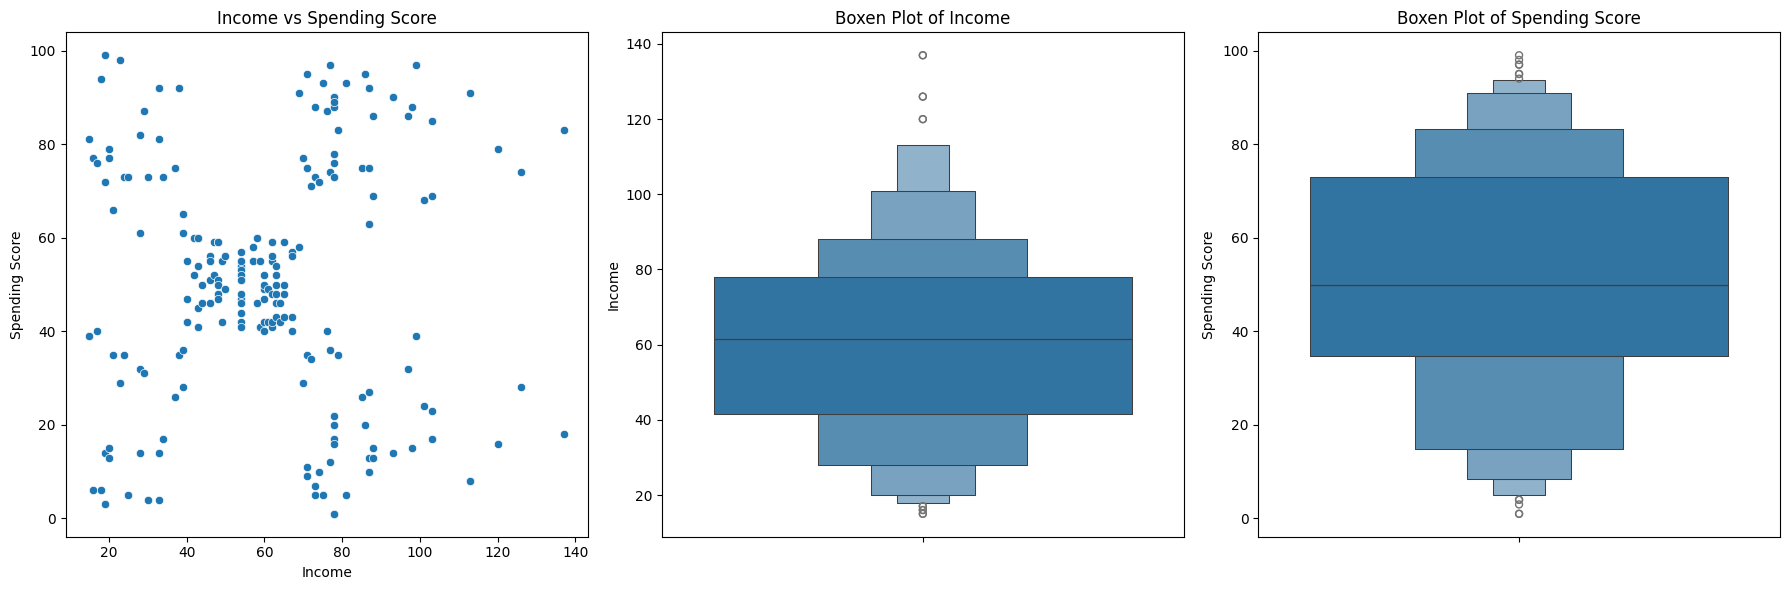

In [5]:
# Create a 1x3 grid for better readability
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for income vs spending_score
sns.scatterplot(x=data['income'], y=data['spending_score'], ax=axes[0])
axes[0].set_title('Income vs Spending Score')
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Spending Score')

# Boxen plot for income
sns.boxenplot(y=data['income'], ax=axes[1])
axes[1].set_title('Boxen Plot of Income')
axes[1].set_ylabel('Income')

# Boxen plot for spending_score
sns.boxenplot(y=data['spending_score'], ax=axes[2])
axes[2].set_title('Boxen Plot of Spending Score')
axes[2].set_ylabel('Spending Score')

# Wrap layout
plt.tight_layout()
plt.show()

In [6]:
# Drop id col, and select numeric vars to compute correlations
data = data.drop(columns=['id'])
numeric_data = data.select_dtypes(include=[np.number])

print(numeric_data.corr())

                     age    income  spending_score
age             1.000000 -0.012398       -0.327227
income         -0.012398  1.000000        0.009903
spending_score -0.327227  0.009903        1.000000


# DBSCAN

The following graph demonstrates how DBSCAN clusters data points:


![DBSCAN Illustration](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/2880px-DBSCAN-Illustration.svg.png)

Source: [Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#/media/File:DBSCAN-Illustration.svg)

The clustering model uses the following hyperparameters for DBSCAN:

**`min_samples`**

Defines the minimum number of points required to form a dense region (i.e. core point). If a point has at least X neighbors within the radius defined by eps, it is considered a core point and forms part of a cluster. If fewer points are found within eps, the point is classified as noise or an edge point.

**Recommended values:**
- For low-dimensional data: `min_samples ≥ D + 1`, where `D` is the number of dimensions, but at least `3`.
- For noisy data or large datasets, a more general rule is `min_samples = 2 · D`.

***`eps`***

The maximum distance between two samples for them to be considered as neighbors. For example, eps = 10 specifies that points within a radius of 10 units will be grouped together. A lower eps value will result in more restrictive clustering, potentially increasing the number of clusters, while a higher value will group points into fewer clusters.

**`metric = "euclidean"`**

Specifies the distance metric to use for measuring the distance between points. In this configuration, Euclidean distance is used, which measures the straight-line distance between two points in the multidimensional space.

**`algorithm = "auto"`**

Allows the most appropriate algorithm for computing nearest neighbors based on the input data and metric. If auto is selected, the model will decide which one is most efficient based on the given data.

**`n_jobs = -1`**

Sets the number of cores of the computer to be used. With n_jobs = -1, the clustering will utilize all available CPU cores, potentially speeding up the computation for large datasets.

---



## Silhouette Score to Find Optimal Cluster Size
The **Silhouette Score** measures how similar a data point is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where higher values indicate that the data points are well-clustered. The score is calculated as:

$$
\text{Silhouette Score} = \frac{b - a}{\max(a, b)}
$$

Where:
- `a` is the average distance to all other points in the same cluster.
- `b` is the minimum average distance to points in a different cluster.

A score close to 1 indicates that the points are correctly assigned to their clusters, while a score near -1 suggests that points are assigned to the wrong clusters.

## References
Schubert, Erich; Sander, Jörg; Ester, Martin; Kriegel, Hans Peter; Xu, Xiaowei (July 2017). **"DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN"**.  _ACM Transactions on Database Systems (TODS)_, **42**(3), 19:1–19:21 [doi:10.1145/3068335](https://doi.org/10.1145/3068335), ISSN 0362-5915, S2CID 5156876.



Cluster Counts:
cluster_id
 0    157
 1     35
-1      8
Name: count, dtype: int64


Cluster Summary (with Percentage Share):
   Cluster  Count  Percentage Share
0        0    157              78.5
1        1     35              17.5
2       -1      8               4.0



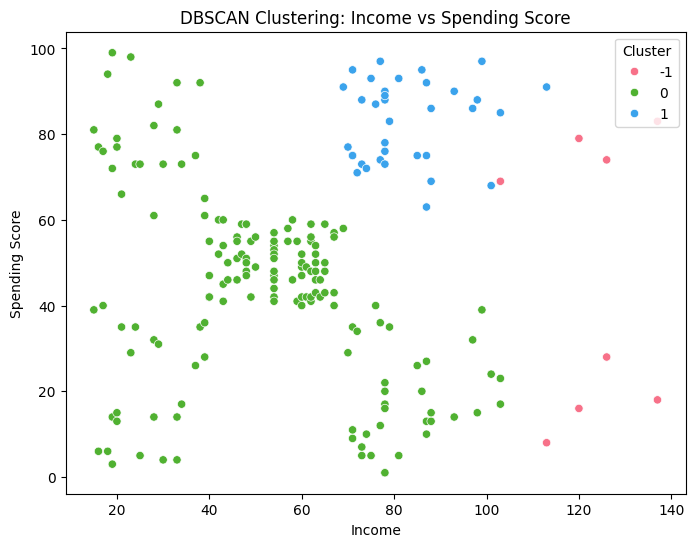

In [7]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['income', 'spending_score']])

# Apply "random" values
eps_value = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Add cluster labels
data['cluster_id'] = dbscan_labels

# Count of points in each cluster
cluster_counts = data['cluster_id'].value_counts()
print("\nCluster Counts:")
print(cluster_counts)
print()

# Calculate percentage share for each cluster
percentage_share = (cluster_counts / len(data)) * 100
cluster_summary = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Count': cluster_counts.values,
    'Percentage Share': percentage_share.values
})

# Print cluster summary
print("\nCluster Summary (with Percentage Share):")
print(cluster_summary)
print()

# Scatter plot to visualize DBSCAN clusters
plt.figure(figsize=(8, 6))
unique_clusters = data['cluster_id'].unique()
palette = sns.color_palette('husl', len(unique_clusters))

sns.scatterplot(
    x=data['income'],
    y=data['spending_score'],
    hue=data['cluster_id'], 
    palette=palette,
    legend='full'
)

plt.title('DBSCAN Clustering: Income vs Spending Score')
plt.xlabel('Income')
plt.ylabel('Spending Score')
plt.legend(title='Cluster', loc='upper right')
plt.show()


# DBSCAN with Optimization

Best Parameters: eps = 0.44715391205796484, min_samples = 12.0

   Cluster Label  Count  Percentage Share
0              1     91              45.5
1             -1     44              22.0
2              2     30              15.0
3              3     23              11.5
4              0     12               6.0



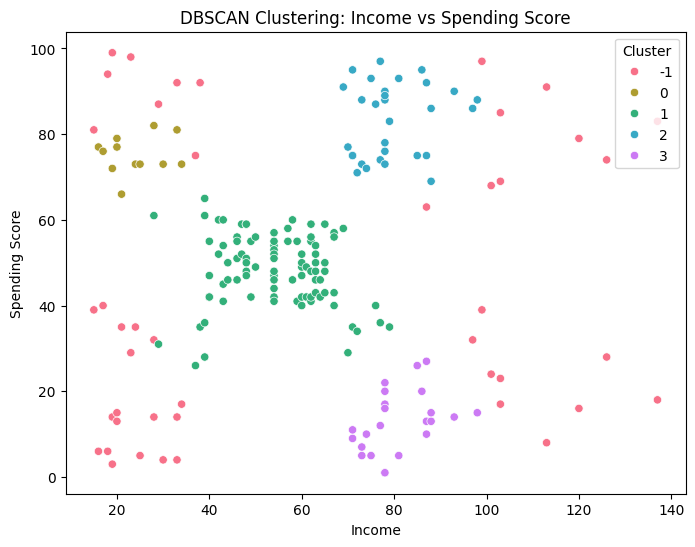

In [8]:
# Normalize the data
scaled_data = StandardScaler().fit_transform(data[['income', 'spending_score']])

# Set min_samples values
min_samples_required = scaled_data.shape[1] * 2
max_samples_required = scaled_data.shape[1] * 14
min_samples_values = np.linspace(min_samples_required, max_samples_required, num=7).astype(int).tolist()

# Set eps values using elbow method
eps_values = []
for min_samples in min_samples_values:
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(scaled_data)
    distances, _ = neighbors_fit.kneighbors(scaled_data)

    distances = np.sort(distances, axis=0)[:, 1]  # Take the 2nd column (nearest neighbor distances)
    x_vals = np.arange(len(distances))
    spline_func = CubicSpline(x_vals, distances)
    first_derivatives = spline_func(x_vals, 1)

    slope_threshold = 1
    closest_slope_index = np.argmin(np.abs(first_derivatives - slope_threshold))
    eps_values.append(distances[closest_slope_index])

# Loop through combinations of eps and min_samples
results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', algorithm='auto', n_jobs=-1)
        labels = dbscan.fit_predict(scaled_data)

        if len(set(labels)) > 1:  # Only evaluate if more than 1 cluster is found
            silhouette_avg = silhouette_score(scaled_data, labels)
            results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': silhouette_avg})

# Find best parameters based on silhouette score
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['silhouette_score'].idxmax()]

print(f"Best Parameters: eps = {best_params['eps']}, min_samples = {best_params['min_samples']}")
print()

# Recreate DBSCAN with best parameters and refit
best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']), metric='euclidean', algorithm='auto', n_jobs=-1)
cluster_labels = best_dbscan.fit_predict(scaled_data)

# Add best cluster labels and print distribution
data['cluster_id'] = cluster_labels

cluster_distribution = data['cluster_id'].value_counts().reset_index()
cluster_distribution.columns = ['Cluster Label', 'Count']
cluster_distribution['Percentage Share'] = 100 * cluster_distribution['Count'] / len(data)
print(cluster_distribution)
print()

# Scatter plot to visualize the best clustering
plt.figure(figsize=(8, 6))
unique_clusters = data['cluster_id'].unique()
palette = sns.color_palette('husl', len(unique_clusters))

sns.scatterplot(
    x=data['income'], 
    y=data['spending_score'], 
    hue=data['cluster_id'], 
    palette=palette,
    legend='full'
)

plt.title('DBSCAN Clustering: Income vs Spending Score')
plt.xlabel('Income')
plt.ylabel('Spending Score')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Final analysis

   Cluster Label  Count  Percentage Share
0              1     91              45.5
1             -1     44              22.0
2              2     30              15.0
3              3     23              11.5
4              0     12               6.0



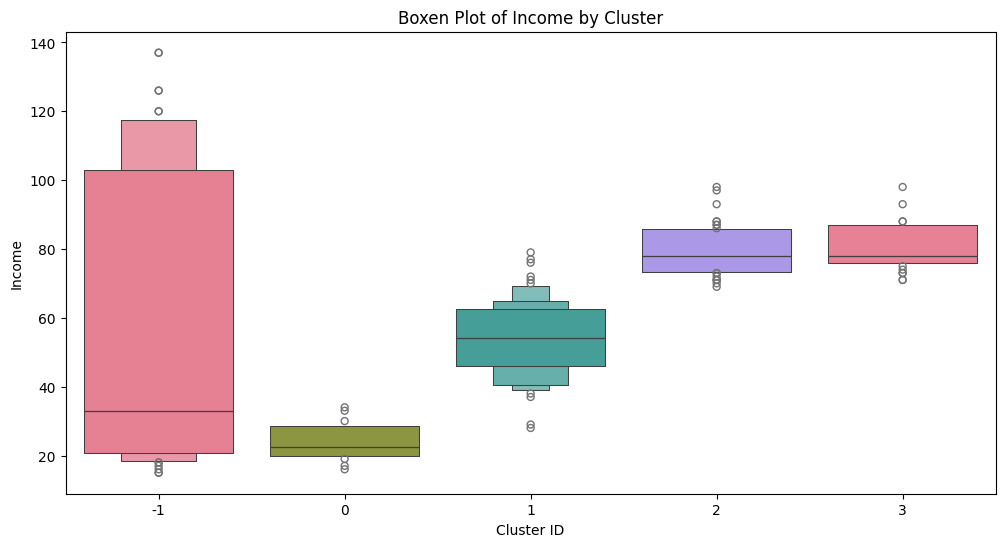

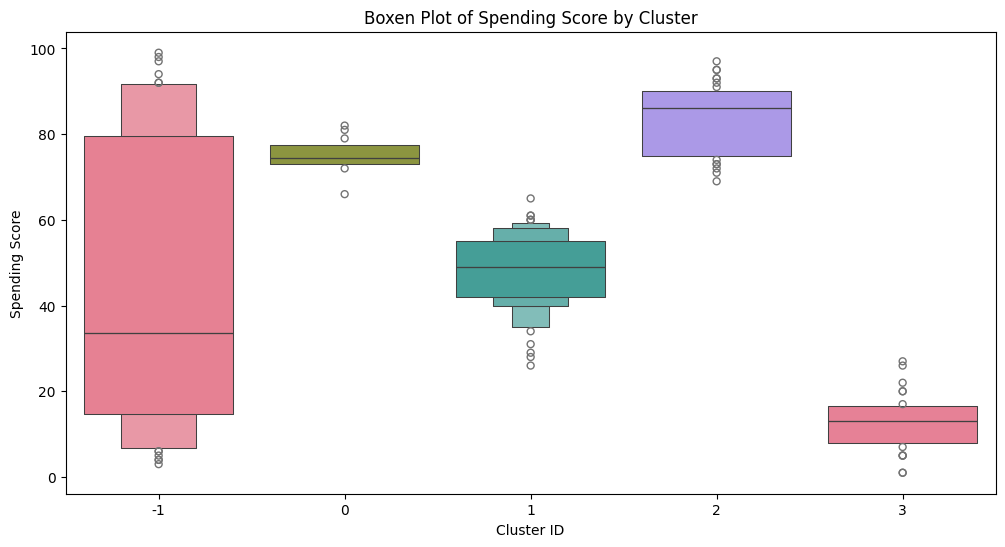

In [9]:
cluster_distribution = data['cluster_id'].value_counts().reset_index()
cluster_distribution.columns = ['Cluster Label', 'Count']
cluster_distribution['Percentage Share'] = 100 * cluster_distribution['Count'] / len(data)
print(cluster_distribution)
print()

# Boxen plots
plt.figure(figsize=(12, 6))
sns.boxenplot(
    x='cluster_id', 
    y='income', 
    data=data, 
    hue='cluster_id', 
    palette='husl',
    legend=False
)
plt.title('Boxen Plot of Income by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Income')
plt.show()

# Boxen plot for spending_score by cluster
plt.figure(figsize=(12, 6))
sns.boxenplot(
    x='cluster_id', 
    y='spending_score', 
    data=data, 
    hue='cluster_id',
    palette='husl',
    legend=False
)
plt.title('Boxen Plot of Spending Score by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Spending Score')
plt.show()
